In [8]:
import os, sys, argparse, importlib, time, inspect
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
if hasattr(__builtins__,'__IPYTHON__'):
    print('Notebook')
    from tqdm.notebook import tqdm
else:
    print('Not notebook')
    from tqdm import tqdm
from tensorflow.keras import backend as K
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import tensorflow_probability as tfp

gpu_devices = tf.config.list_physical_devices('GPU') 
if len(gpu_devices) > 0:
    print("GPU detected")
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('No GPU detected')

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import load_model, Model
import spektral
from sklearn.preprocessing import normalize
from spektral.data import DisjointLoader, BatchLoader, SingleLoader
from importlib import reload
import winsound
import dill
import datetime as dt
import data_load as dl
graph_data=dl.graph_data

Notebook
GPU detected


In [9]:
model=tf.keras.models.load_model('trained_models/probreg_test0')
model.compile()

In [10]:
batch_size=512
dataset=graph_data(restart=0, transform=True, angle=True, unitvec=False)
idx_lists = dataset.index_lists
# Split data
dataset_train = dataset[idx_lists[0]]
dataset_val   = dataset[idx_lists[1]]
dataset_test  = dataset[idx_lists[2]]

# the different loaders work very very differently, beware
loader_test = DisjointLoader(dataset_test, batch_size=batch_size, epochs=1)
print(len(dataset_test))
winsound.Beep(400,300)

Loading data to memory
1000


In [11]:
def loss_func(y_reco, y_true, re=False):
    loss_energy = tf.reduce_mean(abs(tf.subtract(y_reco[:,0], y_true[:,0])))
    kappa=tf.math.abs(y_reco[:,3])
#     tf.print(tf.reduce_mean(kappa))
    azp = y_reco[:,2] #Azimuth prediction
    azt = y_true[:,2] #Azimuth target
    zep = y_reco[:,1] #Zenith prediction
    zet = y_true[:,1] #Zenith target
    s1 = tf.math.sin(zet + azt - azp )
    s2 = tf.math.sin( zet - azt + azp )
    c1 = tf.math.cos( zet - zep )
    c2 = tf.math.cos( zet + zep )
    cos_angle = 0.5*tf.math.abs(tf.math.sin(zep))*( s1 + s2 ) + 0.5*(c1 + c2)
    nlogC = - tf.math.log(kappa) + kappa + tf.math.log( 1 - tf.math.exp( - 2 * kappa) )

    loss_angle = tf.reduce_mean( - kappa*cos_angle + nlogC )
    if not re:
        return loss_angle+loss_energy
    if re:
        return float(loss_angle+loss_energy), [float(loss_energy), float(loss_angle)]

In [12]:
def metrics_angle(y_reco, y_true):
    w_energy = tfp.stats.percentile(tf.math.abs(tf.subtract(y_true[:, 0], y_reco[:, 0])), [50-34, 50, 50+34]) 
#     w_energy         = (energy_quantiles[1] - energy_quantiles[0]) / 1.349
    
    alpha= tf.math.acos(tf.math.sin(y_reco[:, 1])*tf.math.sin(y_true[:, 1])*tf.math.cos(tf.subtract(y_reco[:, 2],y_true[:, 2]))+tf.math.cos(y_reco[:, 1])*tf.math.cos(y_true[:, 1]))
    # tf.print(alpha)
    angle_resi = 180 / np.pi * alpha #degrees
    u_angle         = tfp.stats.percentile(angle_resi, [50-34,50,50+34])

    return w_energy.numpy(), u_angle.numpy()

metrics=metrics_angle


In [13]:
@tf.function(input_signature = loader_test.tf_signature(), experimental_relax_shapes = True)
def test_step(inputs, targets):
    predictions = model(inputs, training = False)
    targets     = tf.cast(targets, tf.float32) 
    out         = loss_func(predictions, targets)

    return predictions, targets, out

def performance_e_alpha(loader, plot=True):
    '''Function to test and plot performance of Graph DL
    input should be dom pos x,y,z , time, charge(log10)
    target should be energy(log10),zenith angle, azimuthal angle, NOT unit vec 
    '''
    loss = 0
    prediction_list, target_list = [], []
    for batch in loader:
        inputs, targets = batch
        predictions, targets, out = test_step(inputs, targets)
        loss           += out
        
        prediction_list.append(predictions)
        target_list.append(targets)

    y_reco  = tf.concat(prediction_list, axis = 0).numpy()
    y_true  = tf.concat(target_list, axis = 0)
    y_true  = tf.cast(y_true, tf.float32).numpy()

    energy = y_true[:, 0]
    counts, bins = np.histogram(energy, bins = 10)

    xs = (bins[1:] + bins[: -1]) / 2

    w_energies, u_angles = [], []
    e_sig, alpha_sig = [], [] 
    for i in range(len(bins)-1):
        idx = np.logical_and(energy > bins[i], energy < bins[i + 1])

        w, u_angle = metrics(y_reco[idx, :], y_true[idx, :])

        w_energies.append(w[1])
        u_angles.append(u_angle[1])
        e_sig.append([w[0], w[2]])
        alpha_sig.append([u_angle[0], u_angle[2]])
    if plot:
        fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (12, 6))

        for a in ax:
            a_ = a.twinx()
            a_.step(xs, counts, color = "gray", zorder = 10, alpha = 0.7, where = "mid")
            a_.set_yscale("log")
            a.set_xlabel("Log Energy")
        
        ax_top = ax

        # Energy reconstruction
        ax_top[0].errorbar(xs, w_energies,yerr=np.array(e_sig).T, fmt='k.',capsize=2,linewidth=1,ecolor='r',label='data')
        ax_top[0].set_title("Energy Performance")
        ax_top[0].set_ylabel(r"$\Delta log(E)$")

        # Angle reconstruction
        ax_top[1].errorbar(xs, u_angles,yerr=np.array(alpha_sig).T, fmt='k.',capsize=2,linewidth=1,ecolor='r',label='data')
        ax_top[1].set_title("Angle Performance")
        ax_top[1].set_ylabel(r"$\Delta \Omega$")

        return fig, ax

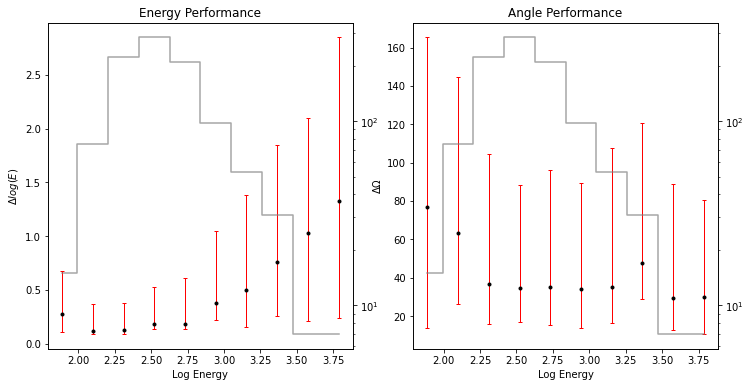

In [14]:
fig, ax = performance_e_alpha(loader_test)